In [1]:
import matplotlib.pyplot as plt
import pvlib
import math
import pandas as pd
import numpy as np
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import time
import pypsa
import sys
from pyomo.environ import *

In [2]:
Load0 = pd.read_csv('Load.csv', sep=';')
Load = Load0.Load
#Load.to_excel('Demand.xls')

poa=pd.read_csv('poa_irr.csv') #index_col=0, #parse_dates=True)
poa_global = poa.poa_global

In [19]:
import numpy as np

from pymoo.model.problem import Problem

class MyProblem(Problem):
    
    PV = poa_global*0.2
    Load = np.array(Load[0:24])
    
    balance_eps = 0.0001 #показатель погрешности выполнения условия баланса мощности (кВт)
    
    DGU12_pmin = 0.3 #минимальная допустимая мощность ДГУ1-2
    DGU34_pmin = 0.3 #минимальная допустимая мощность ДГУ3-4
    P_dgu1 = 320 #мощность 1-го ДГУ, кВт
    P_dgu2 = 320 #мощность 2-го ДГУ, кВт
    P_dgu3 = 520 #мощность 3-го ДГУ, кВт
    P_dgu4 = 520 #мощность 4-го ДГУ, кВт
    
    P_inv = 500
    
    ESS_inv = 24
    
    ESS_c = 700
    
    pDGU1_lb = np.full(shape=24, fill_value=DGU12_pmin*P_dgu1, dtype=np.float)
    pDGU2_lb = np.full(shape=24, fill_value=DGU12_pmin*P_dgu2, dtype=np.float)
    pDGU3_lb = np.full(shape=24, fill_value=DGU34_pmin*P_dgu3, dtype=np.float)
    pDGU4_lb = np.full(shape=24, fill_value=DGU34_pmin*P_dgu4, dtype=np.float)
    
    pDGU1_ub = np.full(shape=24, fill_value=P_dgu1, dtype=np.float)
    pDGU2_ub = np.full(shape=24, fill_value=P_dgu2, dtype=np.float)
    pDGU3_ub = np.full(shape=24, fill_value=P_dgu3, dtype=np.float)
    pDGU4_ub = np.full(shape=24, fill_value=P_dgu4, dtype=np.float)
    
    uDGU1_lb = np.full(shape=24, fill_value=0, dtype=np.int)
    uDGU2_lb = np.full(shape=24, fill_value=0, dtype=np.int)
    uDGU3_lb = np.full(shape=24, fill_value=0, dtype=np.int)
    uDGU4_lb = np.full(shape=24, fill_value=0, dtype=np.int)
    
    uDGU1_ub = np.full(shape=24, fill_value=1, dtype=np.int)
    uDGU2_ub = np.full(shape=24, fill_value=1, dtype=np.int)
    uDGU3_ub = np.full(shape=24, fill_value=1, dtype=np.int)
    uDGU4_ub = np.full(shape=24, fill_value=1, dtype=np.int)
        
#     def __init__(self):
#         super().__init__(n_var=14,
#                          n_obj=1,
#                          n_constr=1,
#                          xl=np.array([self.P_dgu1*self.DGU12_pmin,self.P_dgu2*self.DGU12_pmin,self.P_dgu3*self.DGU34_pmin,
#                                      self.P_dgu4*self.DGU34_pmin, 0, 0, -self.ESS_inv,
#                                       0,0,0,0,0,0,0]),
#                          xu=np.array([self.P_dgu1,self.P_dgu2,self.P_dgu3,self.P_dgu4,
#                                       self.PV[j]*self.P_inv, self.PV[j]*self.P_inv, self.ESS_inv, 
#                                       1,1,1,1,1,1,1]),
#                          elementwise_evaluation=True)

#     def _evaluate(self, x, out, *args, **kwargs):
        
#         f1 = -(x[0]*0.3031*x[7] + x[1]*0.3031*x[8] + x[2]*0.2788*x[9] + x[3]*0.2788*x[10] + 
#               x[4]*x[11] + x[5]*x[12] + x[6]*x[13])
#         #f2 = (x[0]-1)**2 + x[1]**2
#         g1 = ((self.Load[j] - x[0]*x[7] - x[1]*x[8] - x[2]*x[9] - x[3]*x[10] - x[4]*x[11] - x[5]*x[12] -
#               x[6]*x[13])**2) - self.balance_eps
        
#         g2 = 
        
#         #g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
#         #g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

#         out["F"] = [f1]
#         out["G"] = [g1]


# elementwise_problem = MyProblem()
        
        
    def __init__(self):
        super().__init__(n_var=24*8, n_obj=1, n_constr=1, xl=np.concatenate((self.pDGU1_lb, self.pDGU2_lb, self.pDGU3_lb, self.pDGU4_lb, 
                self.uDGU1_lb, self.uDGU2_lb, self.uDGU3_lb, self.uDGU4_lb)), 
                         xu=np.concatenate((self.pDGU1_ub, self.pDGU2_ub, self.pDGU3_ub, self.pDGU4_ub, 
                self.uDGU1_ub, self.uDGU2_ub, self.uDGU3_ub, self.uDGU4_ub)))


    def _evaluate(self, X, out, *args, **kwargs):
        
        f1 = -(X[:,0]*0.3031*X[:,4] + X[:,1]*0.3031*X[:,5] + X[:,2]*0.2788*X[:,6] + X[:,3]*0.2788*X[:,7])
        
        
#         f1 = -(X[:,0]*0.3031*X[:,4] + X[:,1]*0.3031*X[:,5] + X[:,2]*0.2788*X[:,6] + X[:,3]*0.2788*X[:,7])
#         #print(f1)
#         #f2 = (X[:,0]-1)**2 + X[:,1]**2
        
        g1 = (((self.Load[:] - X[:,0]*X[:,4] - X[:,1]*X[:,5] - X[:,2]*X[:,6] - X[:,3]*X[:,7])**2) - self.balance_eps)
        
        
        out["F"] = np.column_stack([f1])
        out["G"] = np.column_stack([g1])
        

In [20]:
c = (['real']*24*4 + ['int']*300*4)

In [21]:
# if the first variable is an integer and the second a real value
mask = (['real']*24*4 + ['int']*24*4)
#mask = ["real", "real", "real", "real", "real", "real", "real", "int", "int", "int", "int", "int", "int", "int"]
# e.g. if first two are integers and third real it would be
# mask = ["int", "int", real"]
# for the purpose of plotting we limit us to two variables here

In [22]:
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

sampling = MixedVariableSampling(mask, {
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random")
})

crossover = MixedVariableCrossover(mask, {
    "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
    "int": get_crossover("int_sbx", prob=1.0, eta=3.0)
})

mutation = MixedVariableMutation(mask, {
    "real": get_mutation("real_pm", eta=3.0),
    "int": get_mutation("int_pm", eta=3.0)
})

In [23]:
import numpy as np

from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize

problem = MyProblem()

algorithm = GA(
    pop_size=24,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True,
)

xx=[]
ff=[]
gg=[]

#for j in range (3000, 3010):

res = minimize(
        problem,
        algorithm,
        ('n_gen', 10000),
        seed=1,
        save_history=True, verbose=True
    )


# xx.append(res.X)
# ff.append(res.F)
# gg.append(res.G)
    
print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)
print("Constraint: %s" % res.G)

# print(xx)
# print(ff)
# print(gg)


NameError: name 'GA' is not defined

In [347]:
res.F

In [148]:
xx1 = []
for el in xx:
    if el is not None:
        if len(el) != 14:
            xx1.append(el[0])
        elif len(el) == 14:
            xx1.append(el)

In [149]:
opf = pd.DataFrame(xx1)
opf.columns=['DGU1_p','DGU2_p', 'DGU3_p', 'DGU4_p', 'PV1_p', 'PV2_p', 'ESS_inv_p',
             'DGU1_status', 'DGU2_status', 'DGU3_status', 'DGU4_status',
            'PV1_status', 'PV2_status', 'ESS_inv_status']
opf['DGU1_p'] = opf['DGU1_p']*opf['DGU1_status']
opf['DGU2_p'] = opf['DGU2_p']*opf['DGU2_status']
opf['DGU3_p'] = opf['DGU3_p']*opf['DGU3_status']
opf['DGU4_p'] = opf['DGU4_p']*opf['DGU4_status']
opf['PV1_p'] = opf['PV1_p']*opf['PV1_status']
opf['PV2_p'] = opf['PV2_p']*opf['PV2_status']
opf['ESS_inv_p'] = opf['ESS_inv_p']*opf['ESS_inv_status']

In [150]:
opf

,DGU1_p,DGU2_p,DGU3_p,DGU4_p,PV1_p,PV2_p,ESS_inv_p,DGU1_status,DGU2_status,DGU3_status,DGU4_status,PV1_status,PV2_status,ESS_inv_status
0,0.000000,112.159067,249.726696,0.0,0.0,0.0,0.000000,0,1,1,0,0,0,0
1,0.000000,113.372739,239.235517,0.0,0.0,0.0,0.000000,0,1,1,0,0,0,0
2,0.000000,113.372739,239.235517,0.0,0.0,0.0,0.000000,0,1,1,0,0,0,0
3,0.000000,104.604530,238.715174,0.0,0.0,0.0,0.000000,0,1,1,0,0,0,0
4,0.000000,104.604530,238.715174,0.0,0.0,0.0,0.000000,0,1,1,0,0,0,0
5,0.000000,104.604530,238.715174,0.0,0.0,0.0,0.000000,0,1,1,0,0,0,0
6,0.000000,112.159067,249.726696,0.0,0.0,0.0,0.000000,0,1,1,0,0,0,0
7,219.077416,0.000000,179.925274,0.0,0.0,0.0,0.000000,1,0,1,0,0,0,0
8,0.000000,248.584845,0.000000,0.0,0.0,0.0,178.252605,0,1,0,0,0,0,1
9,0.000000,248.584845,0.000000,0.0,0.0,0.0,178.252605,0,1,0,0,0,0,1


<AxesSubplot:>

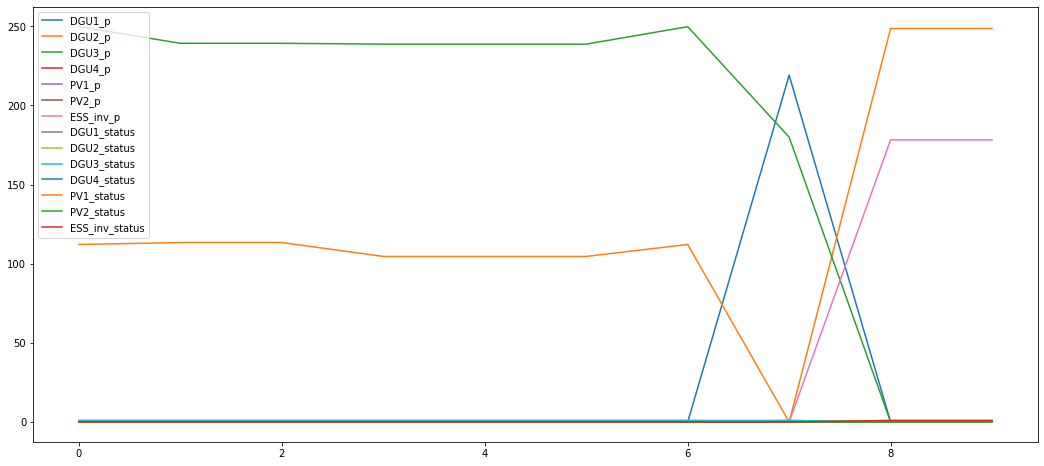

In [151]:
opf.plot(figsize=(18,8))

In [171]:
res.algorithm

In [175]:
res.history[0]

In [176]:
n_evals = []    # corresponding number of function evaluations\
F = []          # the objective space values in each generation
cv = []         # constraint violation in each generation


# iterate over the deepcopies of algorithms
for algorithm in res.history:

    # store the number of function evaluations
    n_evals.append(algorithm.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algorithm.opt

    # store the least contraint violation in this generation
    cv.append(opt.get("CV").min())

    # filter out only the feasible and append
    feas = np.where(opt.get("feasible"))[0]
    _F = opt.get("F")[feas]
    F.append(_F)

In [185]:
res.history[49].opt.get('X')

array([[135.07715033176595, 248.5848452283134, 381.17625585955943,
        427.903883897278, 23289.299875414956, 21174.109303789897,
        178.2525953803654, 0, 1, 0, 0, 0, 0, 1],
       [135.07715033176595, 248.5848452283134, 202.20692936385342,
        427.903883897278, 23289.299875414956, 21026.97437198194,
        178.2525953803654, 0, 1, 0, 0, 0, 0, 1],
       [135.07715033176595, 248.5848452283134, 337.7370521229034,
        427.903883897278, 23416.4166911804, 21174.109303789897,
        178.2525953803654, 0, 1, 0, 0, 0, 0, 1]], dtype=object)

In [184]:
res.history

In [24]:
from pymoo.model.problem import FunctionalProblem

In [25]:
#functional approach

In [30]:
import numpy as np
from pymoo.model.problem import FunctionalProblem
import math

PV = (0.001*poa_global*0.2*5100)/2
Load = np.array(Load)

balance_eps = 0.0001 #показатель погрешности выполнения условия баланса мощности (кВт)

DGU12_pmin = 0.5 #минимальная допустимая мощность ДГУ1-2
DGU34_pmin = 0.5 #минимальная допустимая мощность ДГУ3-4
P_dgu1 = 320 #мощность 1-го ДГУ, кВт
P_dgu2 = 320 #мощность 2-го ДГУ, кВт
P_dgu3 = 520 #мощность 3-го ДГУ, кВт
P_dgu4 = 520 #мощность 4-го ДГУ, кВт

P_inv = 500

ESS_inv = 300

ESS_c = 700
    
SOC_prev = 30


objs = [
    lambda x: x[0]*0.3031*x[7] + x[1]*0.3031*x[8] + x[2]*0.2788*x[9] + x[3]*0.2788*x[10]]    #lambda x: x[0]*x[7]*500 + x[1]*x[8]*500 + x[2]*x[9]*700 + x[3]*x[10]*700 + x[4]*x[11]*5 +
               #x[5]*x[12]*5 + x[6]*x[13]*3


constr_eq = [
    lambda x: ((Load[j] - x[0]*x[7] - x[1]*x[8] - x[2]*x[9] - x[3]*x[10] - x[4] - x[5] -
              x[6])**2)]
#     lambda x: x[7] if sum(DGU1_stat_prev[(j-3950-3):(j-3950)])==3]

    #lambda x: - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8


constr_ieq = [
    lambda x: -SOC_prev + 100*x[6]/ESS_c + 30,
    lambda x: SOC_prev - 100*x[6]/ESS_c - 100,
    lambda x: x[4] - PV[j],
    lambda x: x[5] - PV[j]]




functional_problem = FunctionalProblem(11,
                                       objs,
                                       constr_eq=constr_eq, constr_eq_eps=1e-03, constr_ieq=constr_ieq,
                                       xl=np.array([P_dgu1*DGU12_pmin,P_dgu2*DGU12_pmin,
                                                    P_dgu3*DGU34_pmin,P_dgu4*DGU34_pmin, 0, 0,
                                                    -ESS_inv,
                                      0,0,0,0]),
                                       xu=np.array([P_dgu1,P_dgu2,P_dgu3,P_dgu4, 600, 600,
                                      ESS_inv, 
                                      1,1,1,1]))






In [1121]:
a=[1,2,3,4,5,6]

In [1126]:
a[0:3]

[1, 2, 3]

In [1134]:
sum([0,1,1])

1

<AxesSubplot:>

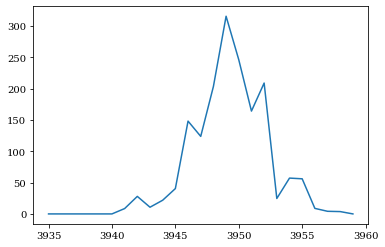

In [1088]:
PV[3935:3960].plot()

In [1089]:
# if the first variable is an integer and the second a real value
# mask = (['real']*300*4 + ['int']*300*4)
mask = ["real", "real", "real", "real", "real", "real", "real", "int", "int", "int", "int"]
# e.g. if first two are integers and third real it would be
# mask = ["int", "int", real"]
# for the purpose of plotting we limit us to two variables here
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableMutation, MixedVariableCrossover

sampling = MixedVariableSampling(mask, {
    "real": get_sampling("real_random"),
    "int": get_sampling("int_random")
})

crossover = MixedVariableCrossover(mask, {
    "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
    "int": get_crossover("int_sbx", prob=1.0, eta=3.0)
})

mutation = MixedVariableMutation(mask, {
    "real": get_mutation("real_pm", eta=3.0),
    "int": get_mutation("int_pm", eta=3.0)
})


In [31]:
import numpy as np

from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize

from pymoo.algorithms.so_pso import PSO
from pymoo.algorithms.so_genetic_algorithm import GA

from pymoo.util.termination.default import MultiObjectiveDefaultTermination

termination = MultiObjectiveDefaultTermination(
    x_tol=1e-8,
    cv_tol=1e-6,
    f_tol=0.0025,
    nth_gen=50,
    n_last=50,
    n_max_gen=1000,
    n_max_evals=100000
)


psos = PSO (pop_size=15)


problem = functional_problem

algorithm = NSGA2(
    pop_size=200,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True,
)

xx=[]
ff=[]
gg=[]

SOC_prev = 30
DGU1_stat_prev = [0, 0, 0]
DGU2_stat_prev = [0, 0, 0]
DGU3_stat_prev = [0, 0, 0]
DGU4_stat_prev = [0, 0, 0]

for j in range (3935, 3960):

    res = minimize(
        problem,
        algorithm,
        seed=1,
        termination = get_termination("n_gen", 500),
        save_history=True, verbose=True
    )

    if res.opt is not None:
        xx.append(res.opt.get('X'))
        if j>=0:
            SOC_prev = SOC_prev - (100*res.opt.get('X')[0][6])/700
            DGU1_stat_prev.append(res.opt.get('X')[0][7])
            DGU2_stat_prev.append(res.opt.get('X')[0][8])
            DGU3_stat_prev.append(res.opt.get('X')[0][9])
            DGU4_stat_prev.append(res.opt.get('X')[0][10])
        ff.append(res.opt.get('F'))
        gg.append(res.opt.get('G'))
    else:
        print('!!!!!!!!!!!!!!!!!!!!!!INFESSIBEL')
        xx.append(res.X)
        ff.append(res.F)
        gg.append(res.G)
    
    
# print("Best solution found: %s" % res.X)
# print("Function value: %s" % res.F)
# print("Constraint violation: %s" % res.CV)
# print("Constraint: %s" % res.G)

# print(xx)
# print(ff)
# print(gg)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 11 but corresponding boolean dimension is 192

In [1092]:
xx

[array([[296.7784188597199, 242.8776963127869, 469.10978386828634,
         295.00015354184154, 0.0, 0.0, -274.28264925278773, 0, 0, 1, 0]],
       dtype=object),
 array([[200.98534263146524, 313.5740550923292, 409.9725675171775, ..., 0,
         0, 0],
        [253.3012729683092, 265.6485057987737, 312.93040881352965, ..., 0,
         0, 0],
        [214.39465969653372, 252.79596121037258, 447.33808450390586, ...,
         0, 0, 0],
        ...,
        [262.614470386339, 215.92776072936252, 459.73238231698, ..., 0, 0,
         0],
        [252.90100695528798, 220.7196087506831, 491.62138258405696, ...,
         0, 0, 0],
        [248.31164619653455, 308.00678236583076, 303.33708452513935, ...,
         0, 0, 0]], dtype=object),
 array([[173.75322380945394, 268.7390909451353, 419.3933046714982,
         325.1209946220674, 0.0, 0.0, -261.6657930876242, 0, 0, 1, 0]],
       dtype=object),
 array([[226.82224957395, 266.15792173664744, 453.61603875626514,
         448.1566052502396, 0.0, 

In [1093]:
xx1 = []
for el in xx:
    if el is not None:
        if len(el) != 11:
            xx1.append(el[0])
        elif len(el) == 11:
            xx1.append(el)

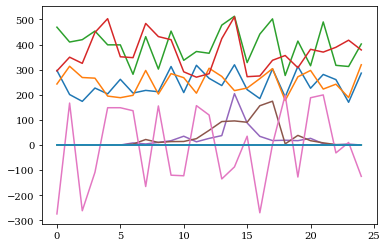

In [1094]:
plt.plot(xx1)

In [1095]:
xx1

[array([296.7784188597199, 242.8776963127869, 469.10978386828634,
        295.00015354184154, 0.0, 0.0, -274.28264925278773, 0, 0, 1, 0],
       dtype=object),
 array([200.98534263146524, 313.5740550923292, 409.9725675171775,
        349.66498067889694, 0.0, 0.0, 167.0042506253663, 0, 0, 0, 0],
       dtype=object),
 array([173.75322380945394, 268.7390909451353, 419.3933046714982,
        325.1209946220674, 0.0, 0.0, -261.6657930876242, 0, 0, 1, 0],
       dtype=object),
 array([226.82224957395, 266.15792173664744, 453.61603875626514,
        448.1566052502396, 0.0, 0.0, -108.44786457461856, 0, 1, 0, 0],
       dtype=object),
 array([203.53281826186634, 194.81469188938058, 398.8544811462362,
        503.0024656205431, 0.0, 0.0, 148.44711363368822, 0, 0, 0, 0],
       dtype=object),
 array([261.5484299525885, 188.40365169330454, 398.67446033274587,
        351.30383433365506, 0.0, 0.0, 148.4625246356333, 0, 0, 0, 0],
       dtype=object),
 array([206.85906276805133, 197.8597707953635, 2

In [1112]:
opf = pd.DataFrame(xx1)
opf.columns=['DGU1_p','DGU2_p', 'DGU3_p', 'DGU4_p', 'PV1_p', 'PV2_p','ESS_inv_p',
             'DGU1_status', 'DGU2_status', 'DGU3_status', 'DGU4_status']
            #'PV1_status', 'PV2_status', 'ESS_inv_status']
opf['Load'] = Load[3935:3960]
opf['PV_real'] = PV[3935:3960]
opf['DGU1_p'] = opf['DGU1_p']*opf['DGU1_status']
opf['DGU2_p'] = opf['DGU2_p']*opf['DGU2_status']
opf['DGU3_p'] = opf['DGU3_p']*opf['DGU3_status']
opf['DGU4_p'] = opf['DGU4_p']*opf['DGU4_status']

#opf['PV1_p'] = opf['PV1_p']*opf['PV1_status']
#opf['PV2_p'] = opf['PV2_p']*opf['PV2_status']
#opf['ESS_inv_p'] = opf['ESS_inv_p']*opf['ESS_inv_status']

In [1111]:
PV[3935:3960]

3935      0.000000
3936      0.000000
3937      0.000000
3938      0.000000
3939      0.000000
3940      0.000000
3941      8.553584
3942     28.004848
3943     10.700888
3944     21.867032
3945     40.477272
3946    148.247050
3947    123.867601
3948    203.565575
3949    315.777330
3950    246.277860
3951    164.282793
3952    209.059564
3953     24.658568
3954     57.226488
3955     56.099902
3956      8.839864
3957      4.187304
3958      3.722048
3959      0.000000
Name: poa_global, dtype: float64

In [1113]:
opf

,DGU1_p,DGU2_p,DGU3_p,DGU4_p,PV1_p,PV2_p,ESS_inv_p,DGU1_status,DGU2_status,DGU3_status,DGU4_status,Load,PV_real
0,0.000000,0.000000,469.109784,0.0,0.000000,0.000000,-274.282649,0,0,1,0,194.856931,NaN
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,167.004251,0,0,0,0,167.020227,NaN
2,0.000000,0.000000,419.393305,0.0,0.000000,0.000000,-261.665793,0,0,1,0,157.741325,NaN
3,0.000000,266.157922,0.000000,0.0,0.000000,0.000000,-108.447865,0,1,0,0,157.741325,NaN
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,148.447114,0,0,0,0,148.462424,NaN
5,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,148.462525,0,0,0,0,148.462424,NaN
6,0.000000,0.000000,0.000000,0.0,8.336395,3.594682,136.552577,0,0,0,0,148.462424,NaN
7,0.000000,296.830234,0.000000,0.0,4.138293,21.958032,-165.215523,0,1,0,0,157.741325,NaN
8,0.000000,0.000000,0.000000,0.0,10.603730,10.194281,155.494924,0,0,0,0,176.299128,NaN
9,0.000000,284.203266,0.000000,0.0,17.126323,13.630233,-120.134062,0,1,0,0,194.856931,NaN


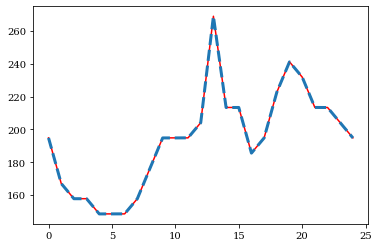

In [1098]:
plt.plot(Load[3935:3960], color='red')
ja1=0
ja2=25
plt.plot(opf.DGU1_p[ja1:ja2]+opf.DGU2_p[ja1:ja2]+opf.DGU3_p[ja1:ja2]+opf.DGU4_p[ja1:ja2]+opf.PV1_p[ja1:ja2]+opf.PV2_p[ja1:ja2]+opf.ESS_inv_p[ja1:ja2], '--', linewidth=3)
plt.show()

In [1065]:
(poa_global*0.2*1400*0.001)[3950]

135.21137389409117

In [1039]:
ja=0
opf.DGU1_p[ja]+opf.DGU2_p[ja]+opf.DGU3_p[ja]+opf.DGU4_p[ja]+opf.PV1_p[ja]+opf.PV2_p[ja]+opf.ESS_inv_p[ja]

213.39788917026345

In [1099]:
init=30
for soc in range (0, 24):
    init=init-100*opf['ESS_inv_p'][soc]/700
    print(init)

69.1832356075411
45.32548551820307
82.70631310214938
98.19886518423775
76.99213466513943
55.78320257433468
36.27569161421181
59.87790924541835
37.66434868186569
54.826357563533875
72.31478141838102
49.91766170256285
32.860830664405555
52.15083444326504
64.59286267864752
59.58947670797231
98.11592771218409
97.7244812816207
69.28945642249086
87.48228196512353
60.590790988906775
32.09473370218225
36.5830204593217
35.13052139885


<AxesSubplot:>

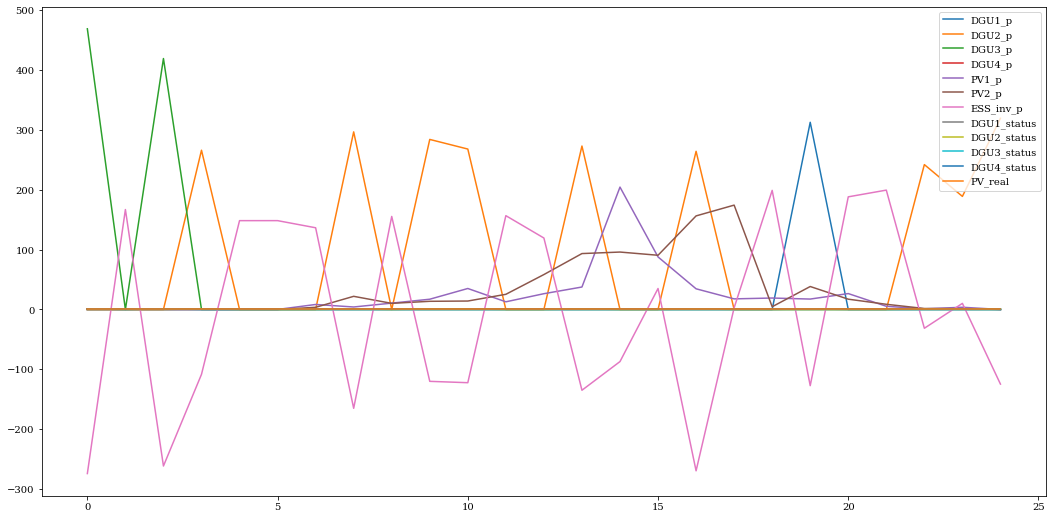

In [1100]:
opf.plot(figsize=(18,9))

<AxesSubplot:>

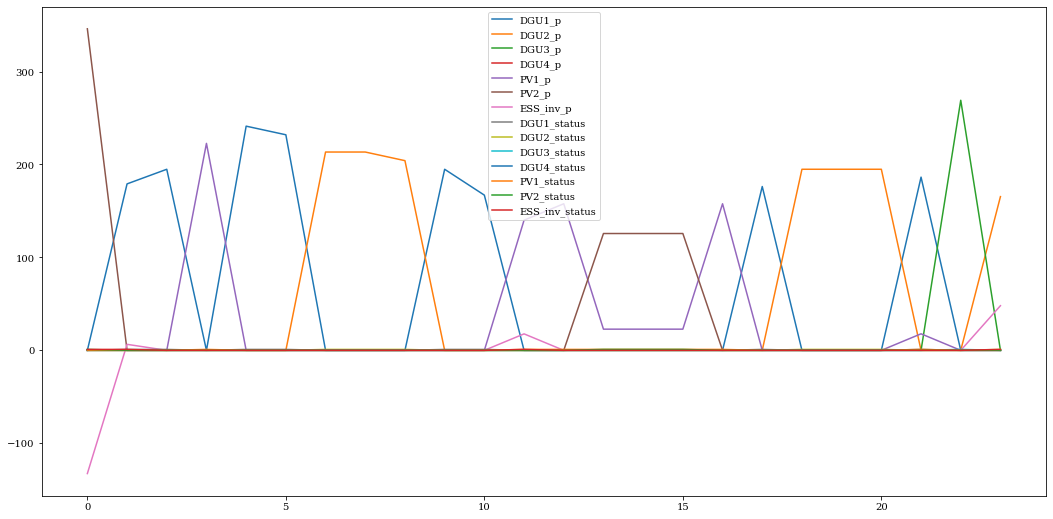

In [1001]:
opf.plot(figsize=(18,9))

In [210]:
Load[3002]

352.5982561043885

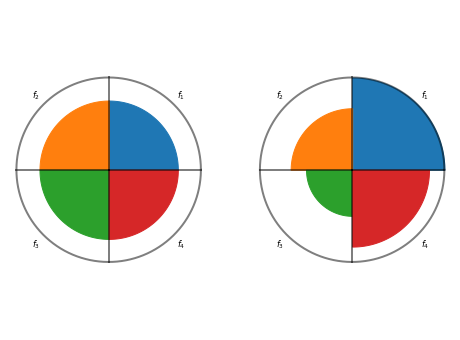

In [247]:
from pymoo.factory import get_problem, get_decision_making, get_reference_directions, get_visualization

ref_dirs = get_reference_directions("das-dennis", 4, n_partitions=12)
F = get_problem("dtlz1").pareto_front(ref_dirs)

weights = np.array([0.25, 0.25, 0.25, 0.25])
a, pseudo_weights = get_decision_making("pseudo-weights", weights).do(F, return_pseudo_weights=True)

weights = np.array([0.4, 0.20, 0.15, 0.25])
b, pseudo_weights = get_decision_making("pseudo-weights", weights).do(F, return_pseudo_weights=True)

plot = get_visualization("petal", bounds=(0, 0.5), reverse=True)
plot.add(F[[a, b]])
plot.show()

In [252]:
functional_problem.pareto_front()

In [287]:
res.opt.get('X')

array([[178.15611120080715, 262.3061840809777, 380.43591440936297,
        338.32412642018664, -226.13544571041714, 0, 0, 1, 0, 0, 1, 1]],
      dtype=object)

In [292]:
len(res.history)

1000

In [296]:
res.opt

In [308]:
np.random.rand(3, 10).shape

(3, 10)

In [ ]:
functional_problem.evaluate(np.random.rand(3, 10))


In [312]:
FunctionalProblem??

In [324]:
PSO??

In [32]:
import numpy as np
from pymoo.model.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, X, out, *args, **kwargs):
        f1 = X[:,0]**2 + X[:,1]**2
        f2 = (X[:,0]-1)**2 + X[:,1]**2

        g1 = 2*(X[:, 0]-0.1) * (X[:, 0]-0.9) / 0.18
        g2 = - 20*(X[:, 0]-0.4) * (X[:, 0]-0.6) / 4.8

        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1, g2])


vectorized_problem = MyProblem()

from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

from pymoo.factory import get_termination

termination = get_termination("n_gen", 40)

from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      40 |  4.27996E+04 |  1.23669E+06 |       1 |            - |            -
    2 |      50 |  2.64684E+04 |  8.22775E+05 |       1 |  1.29972E+01 |        ideal
    3 |      60 |  1.85970E+04 |  5.66867E+05 |       1 |  3.90536E+01 |        ideal
    4 |      70 |  7.34352E+03 |  4.02093E+05 |       1 |  4.90289E+01 |        ideal
    5 |      80 |  2.05607E+02 |  2.80362E+05 |       1 |  2.68628E+01 |        ideal
    6 |      90 |  2.05607E+02 |  1.55040E+05 |       1 |  0.00000E+00 |            f
    7 |     100 |  2.05607E+02 |  7.96274E+04 |       1 |  0.00000E+00 |            f
    8 |     110 |  2.05607E+02 |  4.42290E+04 |       1 |  0.00000E+00 |            f
    9 |     120 |  2.05607E+02 |  2.75153E+04 |       1 |  0.00000E+00 |            f
   10 |     130 |  1.95794E+02 |  1.66930E+04 |       1 |  9.797596750 |        ideal
   11 |     140 |  1.95794E+02 |  1.04489E+04 |       

In [338]:
res.F

In [38]:
from pymoo.model.problem import Problem
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.factory import get_termination
from pymoo.optimize import minimize




class MyProblem(Problem):
    
    total = 5.0        # my own independent variables 
    G = 6.0
    t = 7.0

        
    def __init__(self):                      
        super().__init__(n_var = 3,  # 2 in the case of the example from guide
                         n_obj = 2, 
                         n_constr = 0, 
                         #xl = np.array([-1.0,0.0]),    # for example from guide
                         #xu = np.array([1.0, 10.0]),
                         xl = np.array([-1.0,0.0, -1.0]), 
                         xu = np.array([1.0, 10.0, 1.0]),
                         elementwise_evaluation = True)

    
    def _evaluate(self, x, out, *args, **kwargs):   
        f1 = 1/3*self.total*(1+2*((x[0]-x[2])*np.exp(-self.t/x[1]) + x[2]))
        f2 = 1/3*self.total*self.G*(1-((x[0]-x[2])*np.exp(-self.t/x[1]) + x[2]))
        #f1 = x[0]**2 + x[1]**2         # example from guide
        #f2 = (x[0]-1)**2 + x[1]**2
        
        out["F"] = np.column_stack([f1, f2])
        
elementwise_problem = MyProblem()

#problem = elementwise_problem

algorithm = NSGA2(pop_size = 100,
                  n_offspring = 10, 
                  sampling = get_sampling('real_random'),
                  crossover = get_crossover('real_sbx', prob = 0.9, eta = 15),
                  mutation = get_mutation('real_pm',eta = 20),
                  eliminate_duplicates = True)

termination = get_termination("n_gen", 40)

# method 1
results = minimize(elementwise_problem,
                   algorithm,
                   termination,
                   seed = 1, 
                   save_history = True,
                   verbose = True)

# # method 2
# obj = copy.deepcopy(algorithm)

# obj.setup(problem, termination = termination, seed = 1)

# # until the termination criterion has not been met
# while obj.has_next():
#     # perform an iteration of the algorithm
#     obj.next()
#     # access the algorithm to print some intermediate outputs
#     print(f"gen: {obj.n_gen} n_nds: {len(obj.opt)} constr: {obj.opt.get('CV').min()} ideal: {obj.opt.get('F').min(axis=0)}")
    

# result = obj.result()

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |     100 |            - |            -
    2 |     200 |     100 |  0.008109277 |        ideal
    3 |     300 |     100 |  0.010897439 |        ideal
    4 |     400 |     100 |  0.018096022 |        ideal
    5 |     500 |     100 |  0.002943374 |            f
    6 |     600 |     100 |  0.002728913 |        ideal
    7 |     700 |     100 |  0.002255592 |            f
    8 |     800 |     100 |  0.001629190 |            f
    9 |     900 |     100 |  0.002154793 |            f
   10 |    1000 |     100 |  0.001527426 |            f
   11 |    1100 |     100 |  0.001709248 |            f
   12 |    1200 |     100 |  0.002424614 |            f
   13 |    1300 |     100 |  0.001543189 |            f
   14 |    1400 |     100 |  0.002263113 |            f
   15 |    1500 |     100 |  0.001948077 |            f
   16 |    1600 |     100 |  0.001683943 |            f
   17 |    1700 |     100 |  0.001902484 |      

In [ ]:


class varum()